In [113]:
# Import Libraries
# =========================================================

import numpy as np
import pandas as pd
from collections import Counter
import itertools
from itertools import product
import itertools
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
from heatmap import heatmap, corrplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler

## GLOBAL SETTINGS
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 500)
plt.rcParams["savefig.bbox"] = "tight"

### BEST CUSTOMERS (manual assessment)

init plan:
1. check customers that brought in the most revenue, assuming each active product per month returns a monthly profit. 
2. categorize customers into none, low, mid, high, premium
3. check retention and churn rates per product per revenue class
4. filter for highest retention, lowest churn and highest revenue class
5. see if it's required to add more dimensions (age, region etc)

In [3]:
df = pd.read_csv("Bobs_df_semi_clean.csv")
df.drop("Unnamed: 0", axis = 1, inplace = True)
df["pk_partition"] = pd.to_datetime(df["pk_partition"])
df["entry_date"] = pd.to_datetime(df["entry_date"])
df["pk_cid"] = df["pk_cid"].astype(str)

In [4]:
product_revenue_map = {"short_term_deposit": 60, "loans": 40, "mortgage": 40, "funds": 60, "securities": 60, "long_term_deposit": 60, "credit_card": 40, "pension_plan": 60, "payroll_account": 10, "emc_account": 10, "debit_card": 40, "em_account_p": 10, "em_acount": 10}
products = list(product_revenue_map.keys())

df_product = df[products]
revenues = np.array([product_revenue_map[f] for f in products])
df['total_revenue'] = (df_product * revenues).sum(axis=1)
df_user_revenue = df.groupby('pk_cid')['total_revenue'].sum().reset_index()
df = pd.merge(df, df_user_revenue, on='pk_cid', how='left')

In [5]:
df.rename(columns = {"total_revenue_x": "revenue_month", "total_revenue_y": "revenue_total"}, inplace = True)

In [8]:
df[df["revenue_total"] == 850]

,pk_cid,pk_partition,country_id,Male,age,deceased,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,salary_LN,region,revenue_month,revenue_total
62,1050636,2018-01-28,ES,1,23,0,"136,930.23",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2015-08-10,KHE,1,student,11.83,Cantabria,50,850
364,1050254,2018-01-28,ES,0,22,0,"93,290.43",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2015-08-10,KHD,1,student,11.44,Albacete,50,850
372,1050266,2018-01-28,ES,1,37,0,"128,014.47",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2015-08-10,KHE,1,regular,11.76,Toledo,50,850
527,1050455,2018-01-28,ES,1,57,0,"108,421.98",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2015-08-10,KAT,1,regular,11.59,Madrid,50,850
581,1050384,2018-01-28,ES,1,30,0,"67,345.95",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2015-08-10,KHE,1,student,11.12,Toledo,50,850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962512,1167004,2019-05-28,ES,0,46,0,"82,570.86",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-16,KFC,1,regular,11.32,La Coruna,50,850
5962649,1167054,2019-05-28,ES,1,38,0,"139,758.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-16,KFC,1,regular,11.85,Asturias,50,850
5962676,1167103,2019-05-28,ES,0,34,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-16,KFC,1,regular,NaN,Cordoba,50,850
5962872,1166753,2019-05-28,ES,1,22,0,"86,137.50",0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,2016-08-14,KHE,1,student,11.36,Burgos,110,850


In [9]:
df[df["pk_cid"] == "1166750"]

,pk_cid,pk_partition,country_id,Male,age,deceased,salary,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date,entry_channel,active_customer,segment,salary_LN,region,revenue_month,revenue_total
167821,1166750,2018-01-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
314120,1166750,2018-02-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
531726,1166750,2018-03-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
775767,1166750,2018-04-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
1174216,1166750,2018-05-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
1426430,1166750,2018-06-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
1536964,1166750,2018-07-28,ES,1,21,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
2161405,1166750,2018-08-28,ES,1,22,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
2392337,1166750,2018-09-28,ES,1,22,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850
2647306,1166750,2018-10-28,ES,1,22,0,"55,584.90",0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2016-08-14,KHE,1,student,10.93,Almeria,50,850


<AxesSubplot:ylabel='Frequency'>

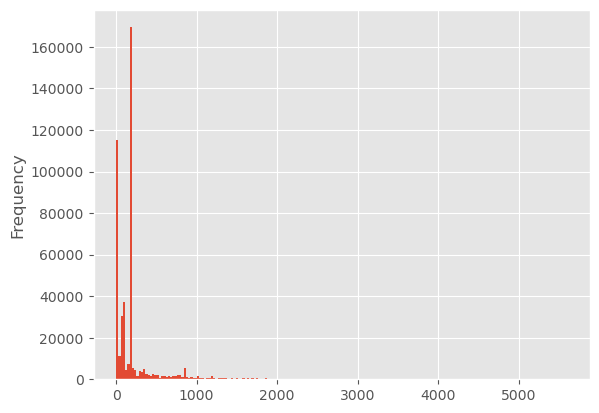

In [10]:
df.groupby("pk_cid")["revenue_total"].min().plot(kind = "hist", bins = 200)

In [11]:
revenue_classes_dict = {
    "None": (-1, 0),
    "Micro": (1, 50),
    "Low": (51, 169),    
    "170": (170, 170.1),    
    "mid": (171, 849),
    "850": (850, 850.1),
    "upper": (851, 1200),
    "high": (1201, 2000),
    "VIP": (2001, 10000)}

df["revenue_class"] = df["revenue_total"].apply(
    lambda x: next(
    (cat for cat, range in revenue_classes_dict.items() if range[0] <= x <= range[1])))

revenue_class
170      167585
None     105989
Low       79482
mid       54873
Micro     20457
upper     10212
high       9865
850        4769
VIP        3141
Name: pk_cid, dtype: int64


<AxesSubplot:xlabel='revenue_class'>

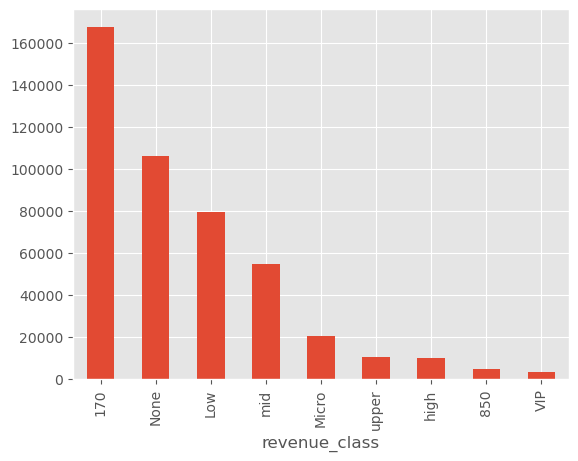

In [12]:
revenue_class_summary = df.groupby("revenue_class")["pk_cid"].nunique().sort_values(ascending = False)
print(revenue_class_summary)
revenue_class_summary.plot(kind = "bar")

<AxesSubplot:xlabel='revenue_class'>

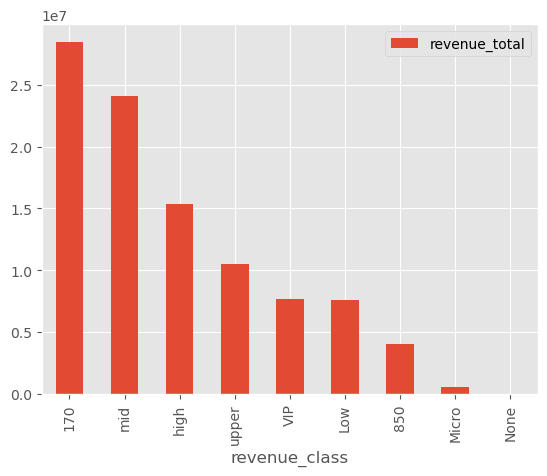

In [13]:
user_revenue = df.groupby(["pk_cid", "revenue_class"])["revenue_total"].min().reset_index()

revenue_per_class = user_revenue.groupby("revenue_class")["revenue_total"].sum().reset_index()
revenue_per_class.sort_values("revenue_total", ascending = False, inplace = True)
revenue_per_class.plot(kind = "bar", x = "revenue_class", y = "revenue_total")

## Thoughts SO FAR
- main income source are 170 (users with just active EM_ACCOUNT over 17 month)
- second main income comes from mid (170-849 revenue). Might be able to learn a lot from this group as it comes with a lot of data observations and a lot of variance in products and retention
- 850 may be worth a look as well, EM_ACCOUNT + DEBIT_CARD Over 17 month uninterrupted. ~4800 users

In [14]:
def check_rev_group(group):
    temp = df[df["revenue_class"] == group]
    print(temp.groupby("pk_cid")[products].mean().mean().sort_values(ascending = False) * 100)
    (temp.groupby("pk_cid")[products].mean().mean().sort_values(ascending = False) * 100).plot(kind = "bar")

em_acount            75.08
debit_card           32.10
emc_account          15.81
payroll_account      13.57
pension_plan          7.37
long_term_deposit     3.91
short_term_deposit    2.02
credit_card           1.65
securities            0.50
funds                 0.24
loans                 0.01
mortgage              0.00
em_account_p          0.00
dtype: float64


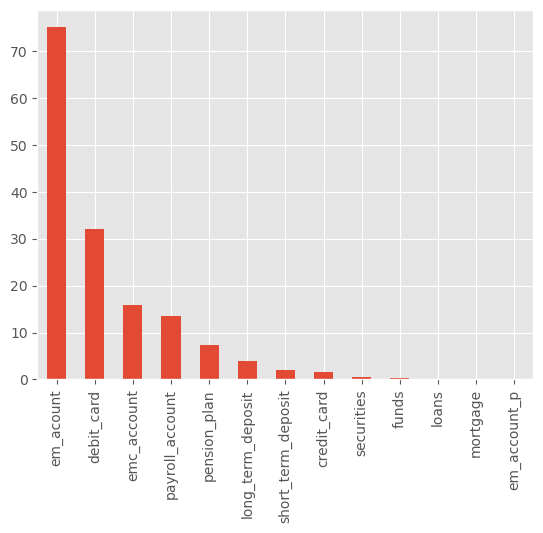

In [15]:
check_rev_group("mid")

### revenue segment generalization

In [34]:
revenue_classes = ["Micro", "Low", "170", "mid", "850", "upper", "high", "VIP"]

results_dict_ = {}
for rev_class in revenue_classes:
    rev_class_df = df[df["revenue_class"] == rev_class]
    avg_retention = rev_class_df.groupby("pk_cid")[products].sum().mean().sort_values(ascending = False)
    results_dict_[rev_class] = avg_retention
avg_retention = pd.DataFrame(results_dict_)

avg_retention.style.background_gradient(axis = None) ## Shows the average retention rate for each product for each revenue class

,Micro,Low,170,mid,850,upper,high,VIP
credit_card,0.002737,0.006643,0.000090,0.239116,0.158524,0.768508,2.225443,8.464820
debit_card,0.012514,0.085604,0.008963,4.422576,16.209897,7.082452,11.863254,14.347023
em_account_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.001665,0.001723,0.000000
em_acount,2.568656,8.684784,16.675729,11.157454,15.980918,8.969644,5.181956,4.137217
emc_account,0.159554,0.269986,0.246854,2.470578,0.101279,4.302585,5.040041,9.920408
funds,0.000000,0.000453,0.000012,0.028156,0.013210,0.471602,0.641156,2.327921
loans,0.000000,0.000038,0.000000,0.000929,0.007129,0.003036,0.011961,0.073543
long_term_deposit,0.000000,0.001132,0.000018,0.475917,0.174041,3.859381,2.242473,3.848456
mortgage,0.000000,0.000025,0.000000,0.000693,0.000000,0.000490,0.005271,0.072270
payroll_account,0.028157,0.085126,0.033476,1.804512,0.793667,5.727477,11.381247,13.657752


In [35]:
results_dict = {}
for rev_class in revenue_classes:
    rev_class_df = df[df["revenue_class"] == rev_class]
    avg_had_product = (rev_class_df.groupby("pk_cid")[products].mean().mean() * 100).sort_values(ascending = False)
    results_dict[rev_class] = avg_had_product
avg_had_product = pd.DataFrame(results_dict)

avg_had_product.style.background_gradient(axis = None) ## Shows how many people in each revenue class had each product at least once on average (in %)

,Micro,Low,170,mid,850,upper,high,VIP
credit_card,0.047490,0.100634,0.001227,1.653307,0.952462,4.743189,13.277643,49.861050
debit_card,0.476729,1.738583,0.147162,32.099646,95.567572,43.528450,70.695156,84.574186
em_account_p,0.000000,0.000000,0.000000,0.000000,0.000000,0.009792,0.010137,0.000000
em_acount,60.970262,91.680974,98.295460,75.081762,94.341762,54.295342,30.872119,24.411508
emc_account,2.355280,2.290193,1.463938,15.813129,0.642435,25.837242,29.890414,58.460691
funds,0.000000,0.012199,0.000114,0.238913,0.096786,2.873693,3.862867,13.733464
loans,0.000000,0.001258,0.000000,0.005789,0.041938,0.018241,0.071847,0.432609
long_term_deposit,0.000000,0.014492,0.000127,3.909360,1.240325,23.562339,13.410881,22.740352
mortgage,0.000000,0.000629,0.000000,0.004087,0.000000,0.002880,0.031007,0.437249
payroll_account,0.571995,1.152505,0.218227,13.567981,4.949272,35.500413,67.768137,80.504072


In [40]:
def retention_vs_had_prod(product):
    product_avg = avg_had_product.loc[product]
    product_results = avg_retention.loc[product]

    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    sns.lineplot(x=product_avg.index, y=product_avg.values, ax=axs[0])
    axs[0].set_ylabel(f"Average % of people who had product")
    axs[0].set_title(f"{product}\nAverage % of people who had product")
    sns.lineplot(x=product_results.index, y=product_results.values, ax=axs[1])
    axs[1].set_ylabel(f"Average retention for {product} in months")
    axs[1].set_title(f"Retention by revenue class in months")
    fig.tight_layout(pad=2)
    plt.show()

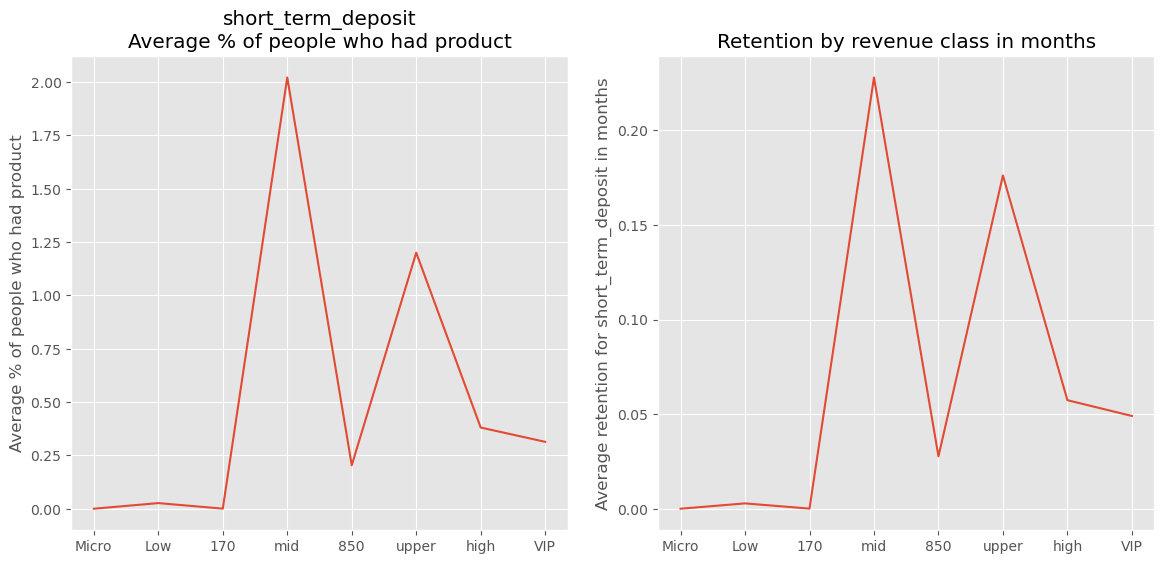

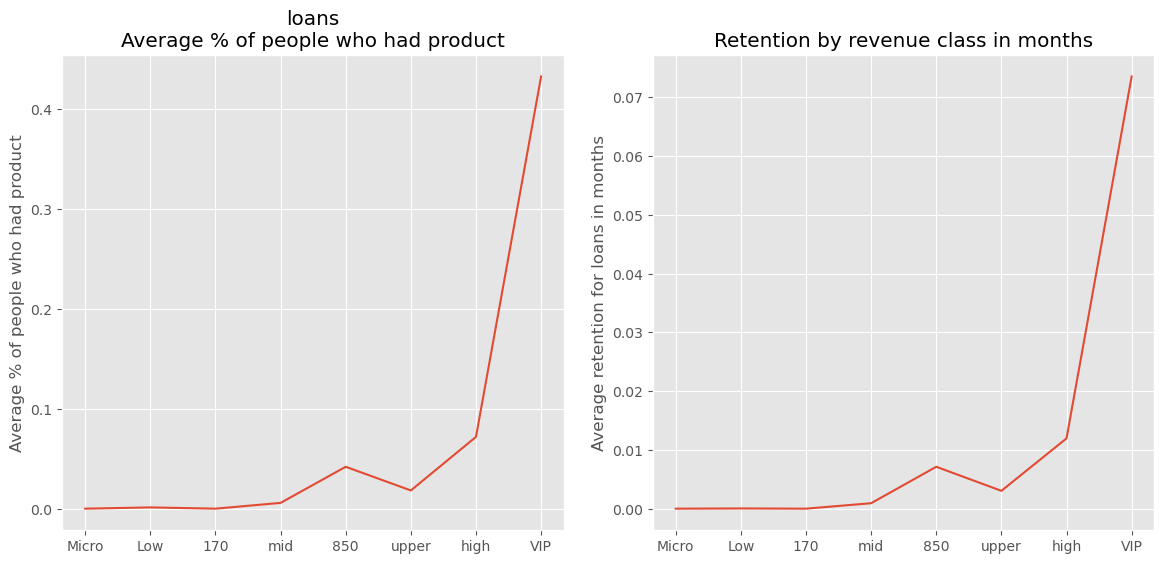

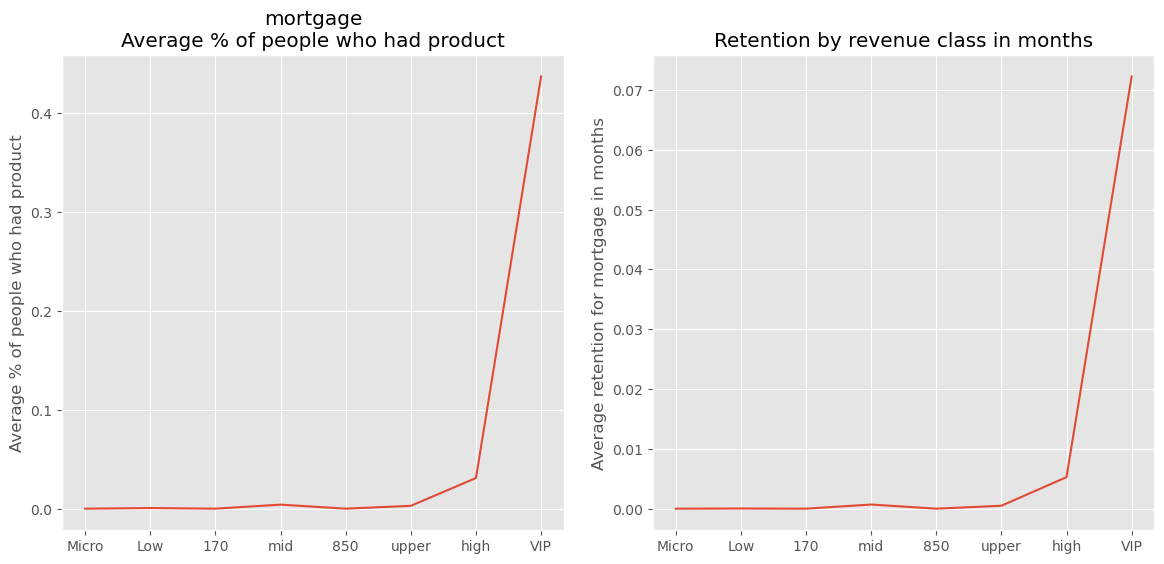

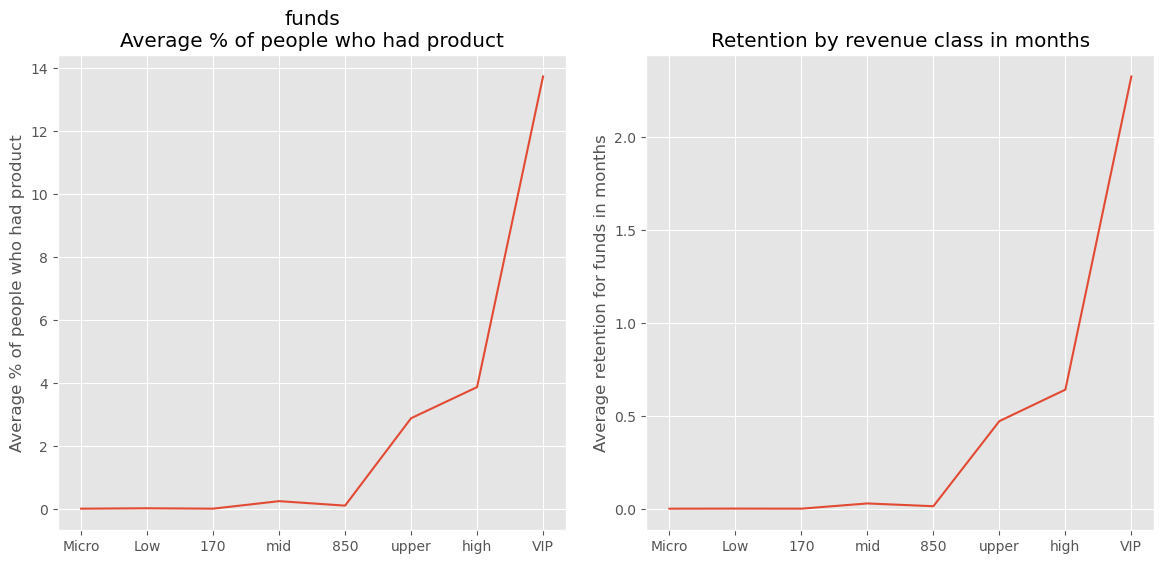

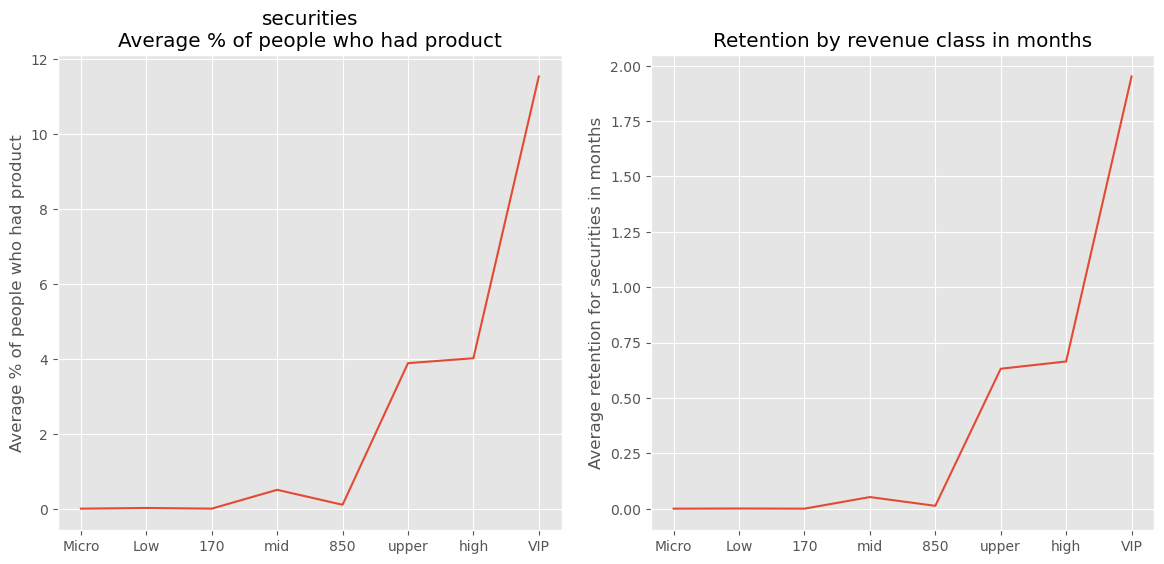

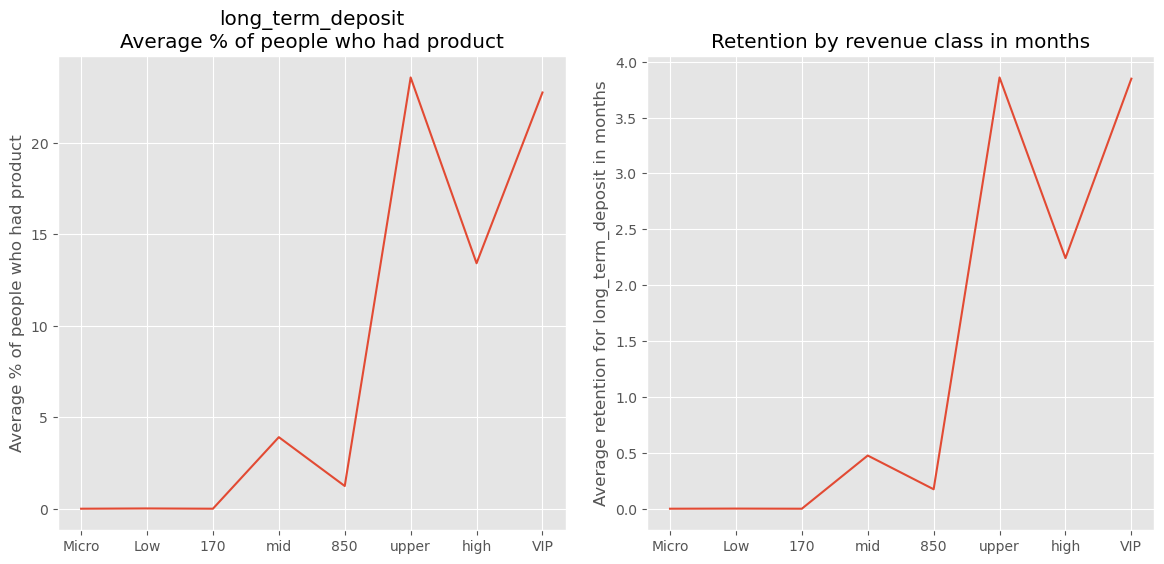

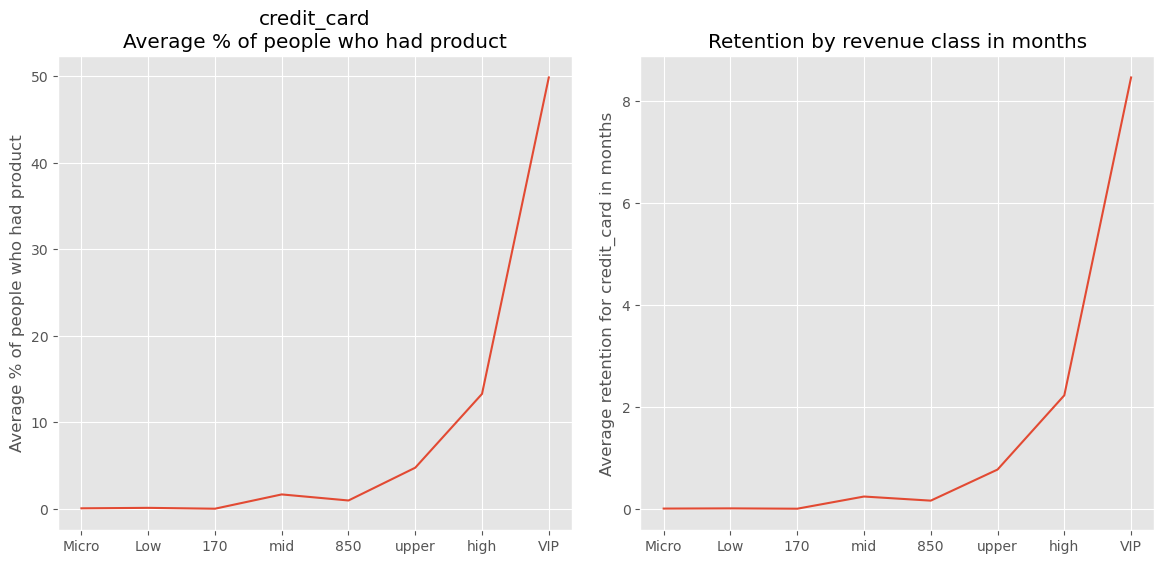

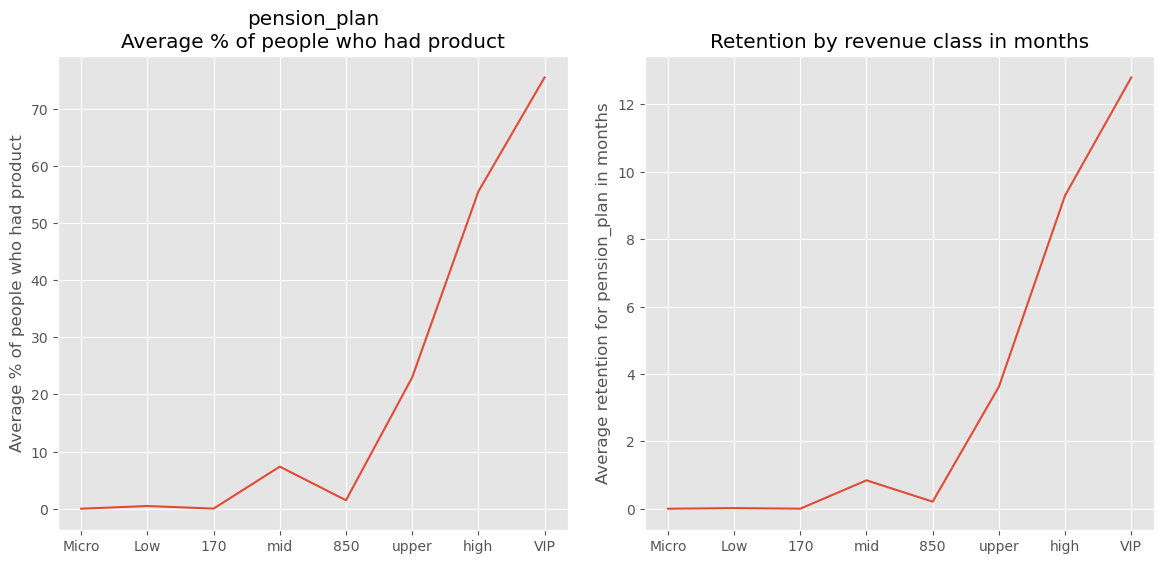

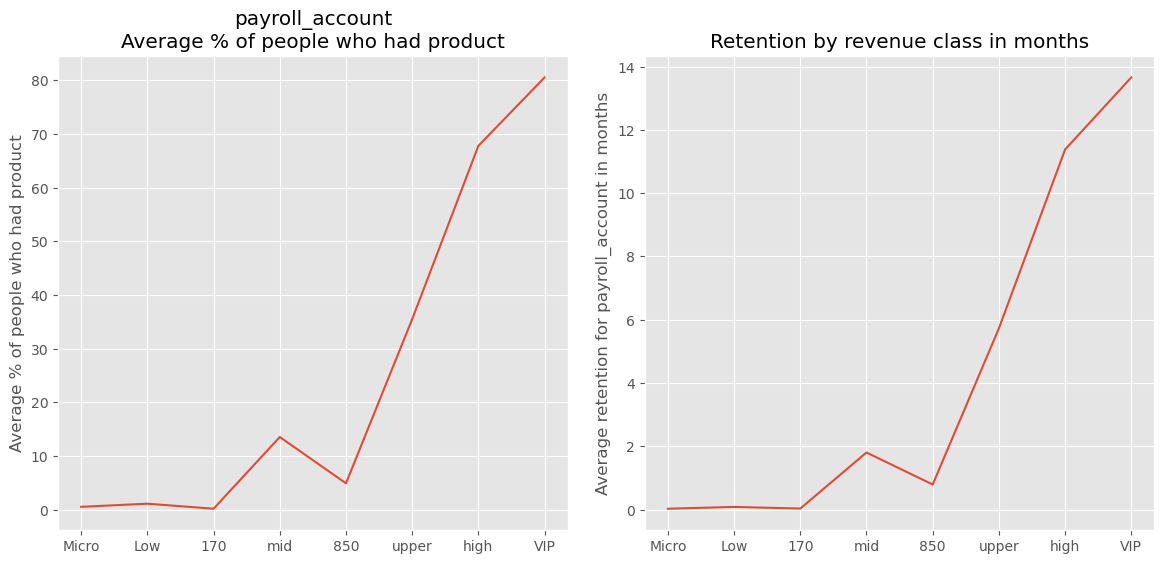

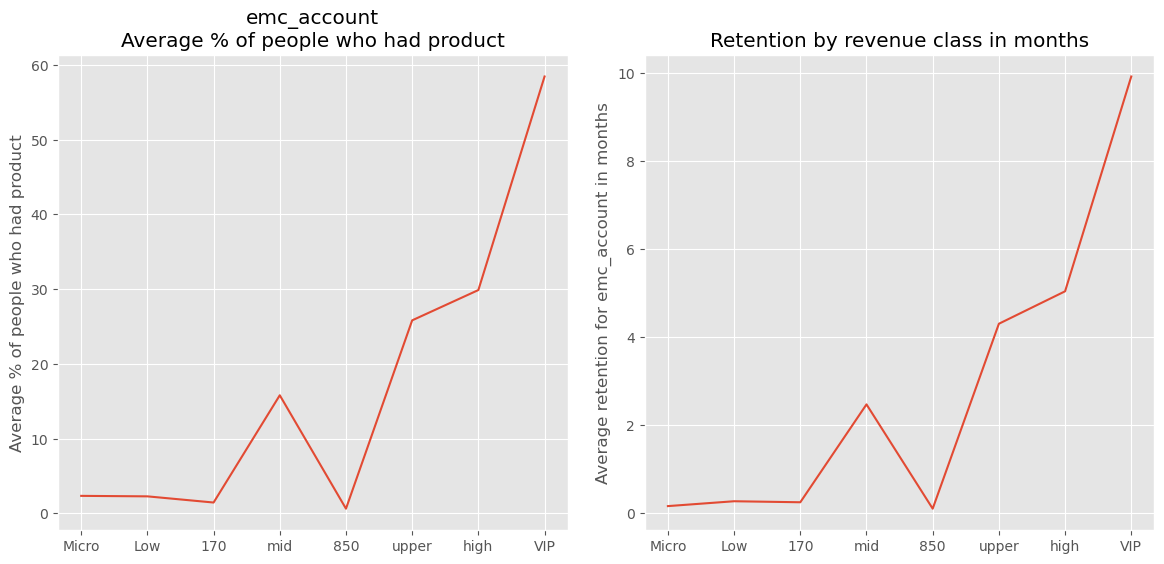

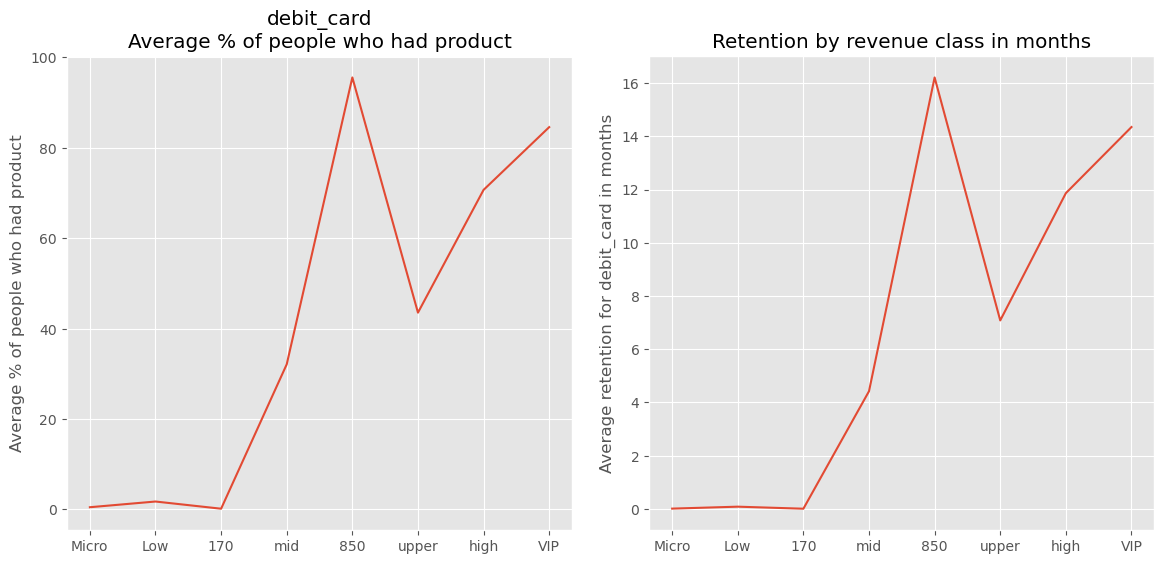

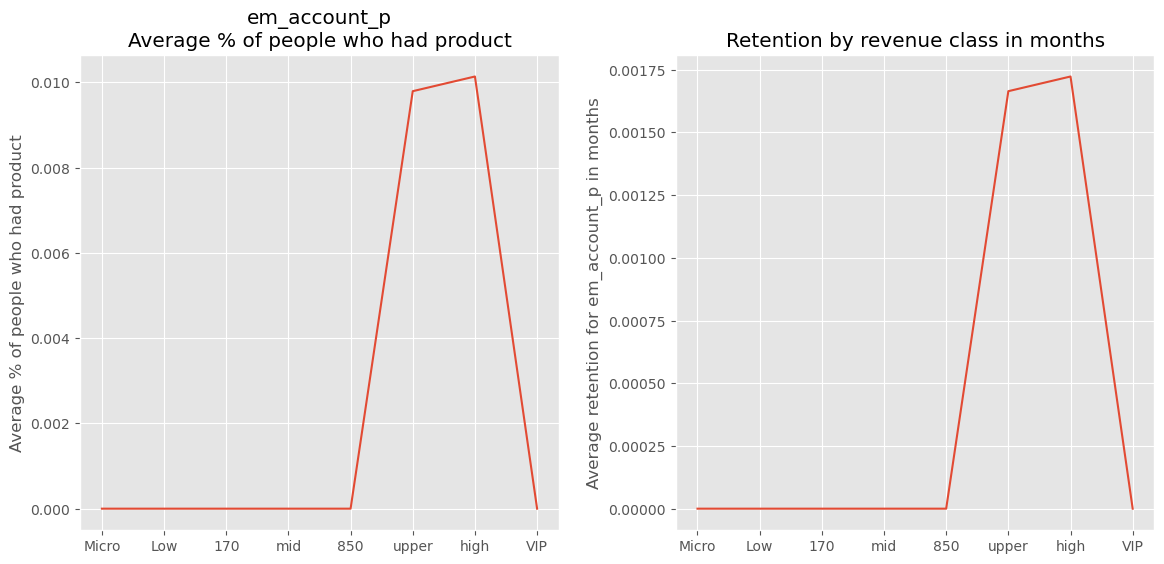

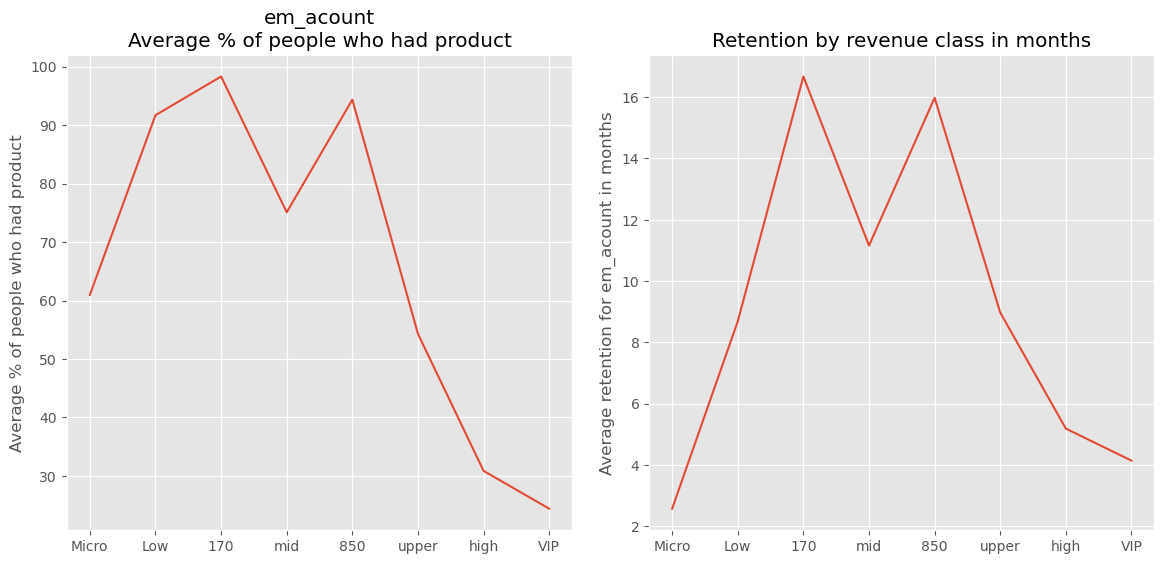

In [41]:
for prod in products:
    retention_vs_had_prod(prod)

In [ ]:
avg_had_product
avg_retention

In [173]:
best_prod = avg_had_product[["upper", "high", "VIP"]]
avg_had_product_best = best_prod[best_prod.gt(30).any(axis = 1)]
avg_had_product_best

,upper,high,VIP
credit_card,4.74,13.28,49.86
debit_card,43.53,70.70,84.57
em_acount,54.30,30.87,24.41
emc_account,25.84,29.89,58.46
payroll_account,35.50,67.77,80.50
pension_plan,22.98,55.51,75.49


In [181]:
best_prod_ = avg_retention[["upper", "high", "VIP"]]
avg_retention_best = best_prod_[best_prod_.gt(5).any(axis = 1)]
avg_retention_best

,upper,high,VIP
credit_card,0.77,2.23,8.46
debit_card,7.08,11.86,14.35
em_acount,8.97,5.18,4.14
emc_account,4.30,5.04,9.92
payroll_account,5.73,11.38,13.66
pension_plan,3.62,9.30,12.80


In [183]:
best_upper_plus_products = list(avg_retention_best.index)
best_upper_plus_products

['credit_card',
 'debit_card',
 'em_acount',
 'emc_account',
 'payroll_account',
 'pension_plan']

In [205]:
def cooccurrence_calculator(data, subset, sub_value, product_list, combinations):
    data = data[data[subset] == sub_value]
    data = data[product_list + ["pk_cid", "pk_partition"]]
    unique_customers = data["pk_cid"].unique()
    print(f"Number of unique customers: {len(unique_customers)}")
    cooccurrence_dict = {}
    for pair in itertools.combinations(product_list, combinations):
        cooccurrence_dict[pair] = {"count": 0, "cooccurrence": 0}

    for cid in unique_customers:
        customer_df = data[data["pk_cid"] == cid]
        customer_prod_df = customer_df.groupby("pk_partition")[product_list].sum()
        for pair in itertools.combinations(product_list, combinations):
            pair_count = (customer_prod_df[list(pair)].sum(axis = 1) == len(pair)).sum()
            cooccurrence_dict[pair]["count"] += (pair_count > 0)
            cooccurrence_dict[pair]["cooccurrence"] += pair_count
        
    cooccurrence_means = {k: v["count"] / len(unique_customers) if v["count"] > 0 else 0 for k, v in cooccurrence_dict.items()}
    cooccurrence_counts = {k: v["count"] for k, v in cooccurrence_dict.items()}
    
    cooccurrence_df = pd.DataFrame.from_dict(cooccurrence_means, orient = "index", columns = ["mean_cooccurrence"])
    cooccurrence_df["user_count"] = pd.Series(cooccurrence_counts)
    cooccurrence_df.index.name = "product_pairs"
    cooccurrence_df.sort_values("mean_cooccurrence", ascending = False, inplace = True)
    
    return cooccurrence_df

In [206]:
madridians = df[df["region"] == "Madrid"]
cooc_vip_madrid = cooccurrence_calculator(
    madridians, "revenue_class", "VIP", best_upper_plus_products, 5)
cooc_vip_madrid.head(10)

Number of unique customers: 1377


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_account, pension_plan)",0.38,530
"(credit_card, debit_card, em_acount, payroll_account, pension_plan)",0.07,100
"(debit_card, em_acount, emc_account, payroll_account, pension_plan)",0.07,95
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.06,76
"(credit_card, debit_card, em_acount, emc_account, payroll_account)",0.05,66
"(credit_card, em_acount, emc_account, payroll_account, pension_plan)",0.05,63


In [207]:
## VIPS 5
cooc_vip_barce = cooccurrence_calculator(
    df, "revenue_class", "VIP", best_upper_plus_products, 5)
cooc_vip_barce.head(10)

Number of unique customers: 3141


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_account, pension_plan)",0.37,1154
"(credit_card, debit_card, em_acount, payroll_account, pension_plan)",0.06,203
"(debit_card, em_acount, emc_account, payroll_account, pension_plan)",0.06,186
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.05,159
"(credit_card, debit_card, em_acount, emc_account, payroll_account)",0.04,128
"(credit_card, em_acount, emc_account, payroll_account, pension_plan)",0.04,121


In [213]:
## VIPS 4
cooc_vip_barce = cooccurrence_calculator(
    df, "revenue_class", "VIP", best_upper_plus_products, 4)
cooc_vip_barce.head(10)

Number of unique customers: 3141


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, payroll_account, pension_plan)",0.63,1971
"(debit_card, emc_account, payroll_account, pension_plan)",0.50,1585
"(credit_card, debit_card, emc_account, payroll_account)",0.38,1184
"(credit_card, emc_account, payroll_account, pension_plan)",0.38,1183
"(credit_card, debit_card, emc_account, pension_plan)",0.37,1172
"(debit_card, em_acount, payroll_account, pension_plan)",0.10,314
"(debit_card, em_acount, emc_account, pension_plan)",0.09,269
"(credit_card, debit_card, em_acount, pension_plan)",0.08,259
"(credit_card, debit_card, em_acount, emc_account)",0.08,253


In [208]:
## HIGH 5
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 5)
cooc_high_barce.head(10)

Number of unique customers: 9865


,mean_cooccurrence,user_count
product_pairs,,
"(credit_card, debit_card, emc_account, payroll_account, pension_plan)",0.03,338
"(debit_card, em_acount, emc_account, payroll_account, pension_plan)",0.01,123
"(credit_card, debit_card, em_acount, payroll_account, pension_plan)",0.01,73
"(credit_card, debit_card, em_acount, emc_account, pension_plan)",0.00,45
"(credit_card, debit_card, em_acount, emc_account, payroll_account)",0.00,36
"(credit_card, em_acount, emc_account, payroll_account, pension_plan)",0.00,23


In [209]:
## HIGH 4
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 4)
cooc_high_barce.head(10)

Number of unique customers: 9865


,mean_cooccurrence,user_count
product_pairs,,
"(debit_card, emc_account, payroll_account, pension_plan)",0.17,1649
"(credit_card, debit_card, payroll_account, pension_plan)",0.12,1195
"(credit_card, debit_card, emc_account, payroll_account)",0.05,485
"(credit_card, emc_account, payroll_account, pension_plan)",0.04,431
"(debit_card, em_acount, payroll_account, pension_plan)",0.04,419
"(credit_card, debit_card, em_acount, emc_account)",0.04,360
"(credit_card, debit_card, emc_account, pension_plan)",0.04,359
"(debit_card, em_acount, emc_account, pension_plan)",0.03,294
"(debit_card, em_acount, emc_account, payroll_account)",0.01,143


In [210]:
## HIGH 3
cooc_high_barce = cooccurrence_calculator(
    df, "revenue_class", "high", best_upper_plus_products, 3)
cooc_high_barce.head(10)

Number of unique customers: 9865


,mean_cooccurrence,user_count
product_pairs,,
"(debit_card, payroll_account, pension_plan)",0.71,6969
"(emc_account, payroll_account, pension_plan)",0.19,1875
"(debit_card, emc_account, payroll_account)",0.18,1823
"(debit_card, emc_account, pension_plan)",0.18,1734
"(credit_card, debit_card, payroll_account)",0.15,1467
"(credit_card, payroll_account, pension_plan)",0.14,1394
"(credit_card, debit_card, pension_plan)",0.12,1230
"(debit_card, em_acount, pension_plan)",0.11,1039
"(debit_card, em_acount, emc_account)",0.10,989


## CONCLUSION:

Customers with high + retention and high + revenue majorly have debit_card, payroll_account and pension_plan.  
The next missing product in order to get to VIP level is a credit_card.

→ find customers that have no credit card yet, but active debit_card, payroll_account and pension_plan throughout 3 most recent months.
→ take the top 10000k

In [284]:
df_last_3m = df[df["pk_partition"] > "2019-03-01"]
df_last_3m["pk_cid"].nunique()

445397

In [294]:
output = df_last_3m.groupby("pk_cid")["debit_card", "payroll_account", "pension_plan", "credit_card"].sum()

# filter the rows based on the conditions
filtered_output = output[(output["credit_card"] == 0) & 
                         (((output["debit_card"] > 2) & (output["pension_plan"] > 2)) |
                          ((output["debit_card"] > 2) & (output["payroll_account"] > 2)) |
                          ((output["payroll_account"] > 2) & (output["pension_plan"] > 2)))]

filtered_output["highest_retention"] = filtered_output.sum(axis = 1)
filtered_output.sort_values("highest_retention", ascending = False, inplace = True)

In [296]:
best_10000_for_credit_card = filtered_output.head(10000)
best_10000_for_credit_card

,debit_card,payroll_account,pension_plan,credit_card,highest_retention
pk_cid,,,,,
1380909,3,3,3,0,9
1217423,3,3,3,0,9
1218102,3,3,3,0,9
1218083,3,3,3,0,9
1443608,3,3,3,0,9
...,...,...,...,...,...
1400070,3,3,0,0,6
1400053,3,3,0,0,6
1400031,3,3,0,0,6
